In [1]:
import os  # Proporciona funciones para interactuar con el sistema operativo.
import pandas as pd  # Manipulación y análisis de datos tabulares (filas y columnas).
import numpy as np  # Operaciones numéricas y matriciales.
import seaborn as sns  # Visualización estadística de datos.
import matplotlib.pyplot as plt  # Creación de gráficos y visualizaciones.
import scipy.cluster.hierarchy as sch  # Biblioteca para realizar el agrupamiento jerárquico.

from sklearn.decomposition import PCA  # Implementación del Análisis de Componentes Principales (PCA).
from sklearn.preprocessing import StandardScaler  # Estandarización de datos para análisis estadísticos.
from sklearn.cluster import KMeans  # Implementación del algoritmo de K-Means para agrupamiento.
from sklearn.metrics import silhouette_score  # Métrica para evaluar la calidad de los resultados del agrupamiento.
from sklearn.metrics import silhouette_samples  # Computa el coeficiente de silueta para cada muestra.

In [2]:
# Establecemos nuestro escritorio de trabajo
os.chdir('C:\\Users\\angel\\OneDrive - Universidad Complutense de Madrid (UCM)\\Documentos Compartidos\\Master\\Tareas_Master\\MineriaDeDatos\\Parte2')

In [3]:
import FuncionesMineria2 as fm2
import FuncionesMineria as fm

In [4]:
# Cargo los datos
datos = sns.load_dataset('penguins')

In [5]:
# Comprobamos el tipo de formato de las variables variable que se ha asignado en la lectura
datos.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

In [6]:
# Genera una lista con los nombres de las variables.
variables = list(datos.columns)

In [7]:
# Comprobamos el número de valores distintos en cada variable
fm.cuentaDistintos(datos)

,Columna,Distintos
0,bill_length_mm,165
1,bill_depth_mm,81
2,flipper_length_mm,56
3,body_mass_g,95


In [8]:
# Seleccionar las columnas numéricas del DataFrame
numericas = datos.select_dtypes(include=['int', 'int32', 'int64','float', 'float32', 'float64']).columns.to_list()

In [9]:
# Seleccionar las columnas categóricas del DataFrame
categoricas = [variable for variable in variables if variable not in numericas]

In [10]:
# Frecuencias de los valores en las variables categóricas
fm.analizar_variables_categoricas(datos)

{'species':              n         %
 Adelie     152  0.441860
 Gentoo     124  0.360465
 Chinstrap   68  0.197674,
 'island':              n         %
 Biscoe     168  0.488372
 Dream      124  0.360465
 Torgersen   52  0.151163,
 'sex':           n         %
 Male    168  0.504505
 Female  165  0.495495}

In [11]:
# Descriptivos variables numéricas mediante función describe() de Python
descriptivos_num = datos.describe().T

# Añadimos más descriptivos a los anteriores
for num in numericas:
    descriptivos_num.loc[num, "Asimetria"] = datos[num].skew()
    descriptivos_num.loc[num, "Kurtosis"] = datos[num].kurtosis()
    descriptivos_num.loc[num, "Mediana"] = datos[num].median()
    descriptivos_num.loc[num, "Rango"] = np.ptp(datos[num].dropna().values)

In [12]:
descriptivos_num

,count,mean,std,min,25%,50%,75%,max,Asimetria,Kurtosis,Mediana,Rango
bill_length_mm,342.0,43.921930,5.459584,32.1,39.225,44.45,48.5,59.6,0.053118,-0.876027,44.45,27.5
bill_depth_mm,342.0,17.151170,1.974793,13.1,15.600,17.30,18.7,21.5,-0.143465,-0.906866,17.30,8.4
flipper_length_mm,342.0,200.915205,14.061714,172.0,190.000,197.00,213.0,231.0,0.345682,-0.984273,197.00,59.0
body_mass_g,342.0,4201.754386,801.954536,2700.0,3550.000,4050.00,4750.0,6300.0,0.470329,-0.719222,4050.00,3600.0


In [13]:
# Muestra valores perdidos
datos[variables].isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

# Comenzamos con la depuración de los datos

In [14]:
# A veces los 'nan' vienen como como una cadena de caracteres, los modificamos a perdidos.
for x in categoricas:
    datos[x] = datos[x].replace('nan', np.nan) 

In [15]:
# La proporción de valores atípicos se calcula dividiendo la cantidad de valores atípicos por el número total de filas
resultados = {x: fm.atipicosAmissing(datos[x])[1] / len(datos) for x in numericas}

# Modifico los atipicos como missings
for x in numericas:
    datos[x] = fm.atipicosAmissing(datos[x])[0]

In [16]:
# Muestra proporción de valores perdidos por cada variable (guardo la información)
prop_missingsVars = datos.isna().sum()/len(datos)

In [17]:
# Creamos la variable prop_missings que recoge el número de valores perdidos por cada observación
datos['prop_missings'] = datos.isna().mean(axis = 1)

In [18]:
# Realizamos un estudio descriptivo básico a la nueva variable
datos['prop_missings'].describe()

count    344.000000
mean       0.007890
std        0.058720
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.714286
Name: prop_missings, dtype: float64

In [19]:
# Calculamos el número de valores distintos que tiene la nueva variable
len(datos['prop_missings'].unique())

3

In [20]:
# Elimino las observaciones con mas de la mitad de datos missings (hay 2)
eliminar = datos['prop_missings'] > 0.5
datos = datos[~eliminar]

In [21]:
# Transformo la nueva variable en categórica (ya que tiene pocos valores diferentes)
datos["prop_missings"] = datos["prop_missings"].astype(str)

In [22]:
# Frecuencias de los valores en las variables categóricas
fm.analizar_variables_categoricas(datos)

{'species':              n         %
 Adelie     151  0.441520
 Gentoo     123  0.359649
 Chinstrap   68  0.198830,
 'island':              n         %
 Biscoe     167  0.488304
 Dream      124  0.362573
 Torgersen   51  0.149123,
 'sex':           n         %
 Male    168  0.504505
 Female  165  0.495495,
 'prop_missings':                        n         %
 0.0                  333  0.973684
 0.14285714285714285    9  0.026316}

In [23]:
# Elimino las variables con mas de la mitad de datos missings (no hay ninguna)
eliminar = [prop_missingsVars.index[x] for x in range(len(prop_missingsVars)) if prop_missingsVars[x] > 0.5]
datos = datos.drop(eliminar, axis = 1)

In [24]:
# Agrego 'prop_missings' a la lista de nombres de variables input
variables.append('prop_missings')
categoricas.append('prop_missings')

# Imputaciones

In [25]:
# Imputo todas las cualitativas, seleccionar el tipo de imputacion: moda o aleatorio
for x in categoricas:
    datos[x] = fm.ImputacionCuali(datos[x], 'aleatorio')

In [26]:
# Muestra valores perdidos que nos quedan
datos[variables].isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
prop_missings        0
dtype: int64

In [27]:
# Frecuencias de los valores en las variables categóricas
fm.analizar_variables_categoricas(datos)

{'species':              n         %
 Adelie     151  0.441520
 Gentoo     123  0.359649
 Chinstrap   68  0.198830,
 'island':              n         %
 Biscoe     167  0.488304
 Dream      124  0.362573
 Torgersen   51  0.149123,
 'sex':           n    %
 Male    171  0.5
 Female  171  0.5,
 'prop_missings':                        n         %
 0.0                  333  0.973684
 0.14285714285714285    9  0.026316}

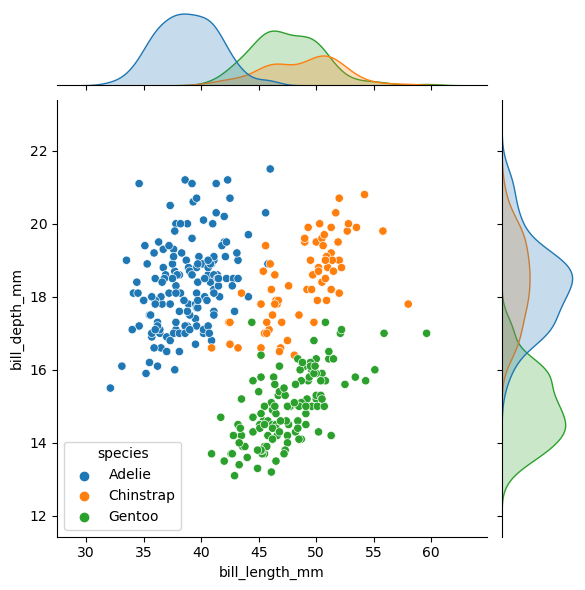

In [28]:
sns.jointplot(data=datos, x="bill_length_mm", y="bill_depth_mm", hue="species")
plt.show()

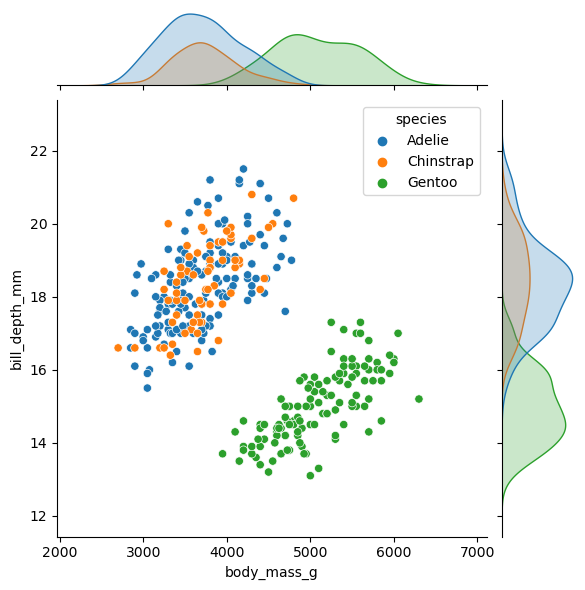

In [29]:
sns.jointplot(data=datos, x="body_mass_g", y="bill_depth_mm", hue="species")
plt.show()

In [30]:
# Calcula y representación de la matriz de correlación entre las 
# variables del DataFrame 'notas'.
R = datos.corr()

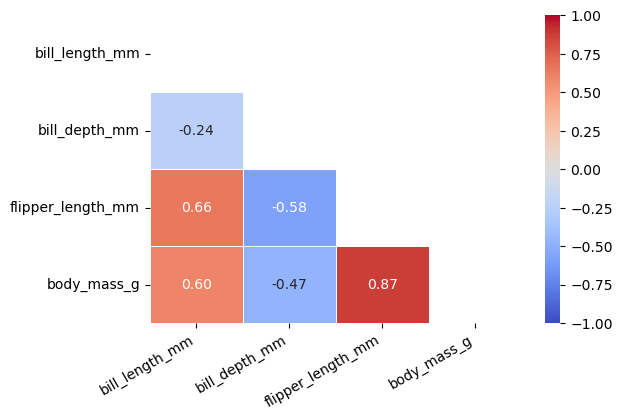

In [31]:
# Crea una nueva figura de tamaño 10x8 pulgadas para el gráfico.
plt.figure(figsize=(6, 4))

# Crear una máscara para ocultar la mitad superior de la matriz de correlación (triangular superior)
mask = np.triu(np.ones_like(R, dtype=bool))

# Genera un mapa de calor (heatmap) de la matriz de correlación 'R' utilizando Seaborn.
# 'annot=True' agrega los valores de correlación en las celdas.
# 'cmap' establece el esquema de colores (en este caso, 'coolwarm' para colores fríos y cálidos).
# 'fmt' controla el formato de los números en las celdas ('.2f' para dos decimales).
# 'linewidths' establece el ancho de las líneas que separan las celdas.
# 'mask' establece unna mascara para la matriz
# 'vmin' establece el valor minimo de la matriz
# 'vmax' establece el valor maximo de la matriz
sns.heatmap(R, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask, vmin=-1, vmax=1)
plt.xticks(rotation=30, ha='right')
plt.show()

# Analisis PCA

In [32]:
# Estandarizamos los datos:
# Utilizamos StandardScaler() para estandarizar (normalizar) las variables.
# - StandardScaler calcula la media y la desviación estándar de las variables numéricas durante el ajuste.
# - Luego, utiliza estos valores para transformar las variables numéricas de manera que tengan media 0 y desviación estándar 1.
# - El método fit_transform() realiza ambas etapas de ajuste y transformación en una sola llamada.
# Finalmente, convertimos la salida en un DataFrame usando pd.DataFrame().
datos_estandarizados = pd.DataFrame(
    StandardScaler().fit_transform(datos[numericas]),  # Datos estandarizados
    columns=['{}_z'.format(numericas) for numericas in numericas],  # Nombres de columnas estandarizadas
    index=datos[numericas].index  # Índices (etiquetas de filas) del DataFrame
)

numericas_estandarizados = datos_estandarizados.columns.to_list()

In [33]:
# Crea una instancia de Análisis de Componentes Principales (ACP):
# - Utilizamos PCA(n_components=4) para crear un objeto PCA que realizará un análisis de componentes principales.
# - Establecemos n_components en 4 para retener el maximo de las componentes principales (maximo= numero de variables).
pca = PCA(n_components=4)

In [34]:
# Aplicar el Análisis de Componentes Principales (ACP) a los datos estandarizados:
# - Usamos pca.fit(notas_estandarizadas) para ajustar el modelo de ACP a los datos estandarizados.
fit = pca.fit(datos_estandarizados)

In [35]:
# Obtener los autovalores asociados a cada componente principal.
autovalores = fit.explained_variance_

# Obtener la varianza explicada por cada componente principal como un porcentaje de la varianza total.
var_explicada = fit.explained_variance_ratio_*100

# Calcular la varianza explicada acumulada a medida que se agregan cada componente principal.
var_acumulada = np.cumsum(var_explicada)

In [36]:
# Crear un DataFrame de pandas con los datos anteriores y establecer índice.
data = {'Autovalores': autovalores, 'Variabilidad Explicada': var_explicada, 'Variabilidad Acumulada': var_acumulada}
tabla = pd.DataFrame(data, index=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)]) 

In [37]:
resultados_pca = pd.DataFrame(fit.transform(datos_estandarizados), 
                              columns=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)],
                              index=datos_estandarizados.index)

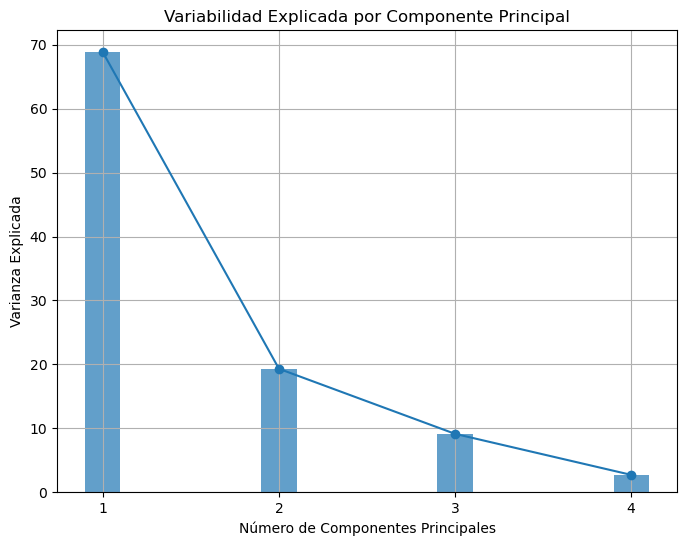

In [38]:
fm2.plot_varianza_explicada(var_explicada, fit.n_components_)

In [39]:
for x in range(0,len(autovalores)):
    print(f'Componente {x+1}: {autovalores[x].round(2)}')

Componente 1: 2.76
Componente 2: 0.77
Componente 3: 0.37
Componente 4: 0.11


In [40]:
for x in range(0,len(var_explicada)):
    print(f'Varianza explicada {x+1}: {var_explicada[x].round(2)}')

Varianza explicada 1: 68.84
Varianza explicada 2: 19.31
Varianza explicada 3: 9.13
Varianza explicada 4: 2.71


In [41]:
# Crea una instancia de ACP con las dos primeras componentes que nos interesan y aplicar a los datos.
pca = PCA(n_components=2)
fit = pca.fit(datos_estandarizados)

In [42]:
# Obtener los autovalores asociados a cada componente principal.
autovalores = fit.explained_variance_

# Obtener los autovectores asociados a cada componente principal y transponerlos.
autovectores = pd.DataFrame(pca.components_.T, 
                            columns = ['Autovector {}'.format(i) for i in range(1, fit.n_components_+1)],
                            index = ['{}_z'.format(variable) for variable in numericas])

# Calculamos las dos primeras componentes principales
resultados_pca = pd.DataFrame(fit.transform(datos_estandarizados), 
                              columns=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)],
                              index=datos_estandarizados.index)

# Añadimos las componentes principales a la base de datos estandarizada.
notas_z_cp = pd.concat([datos_estandarizados, resultados_pca], axis=1)

In [43]:
autovectores

,Autovector 1,Autovector 2
bill_length_mm_z,0.455250,0.597031
bill_depth_mm_z,-0.400335,0.797767
flipper_length_mm_z,0.576013,0.002282
body_mass_g_z,0.548350,0.084363


In [44]:
# Cálculo de las correlaciones entre las variables originales y las componentes seleccionadas.
# Guardamos el nombre de las variables del archivo conjunto (variables y componentes).
variables_cp = notas_z_cp.columns

# Calculamos las correlaciones y seleccionamos las que nos interesan (variables contra componentes).
correlacion = pd.DataFrame(np.corrcoef(datos_estandarizados.T, resultados_pca.T), 
                           index = variables_cp, columns = variables_cp)

n_variables = fit.n_features_in_
correlaciones_notas_con_cp = correlacion.iloc[:fit.n_features_in_, fit.n_features_in_:]

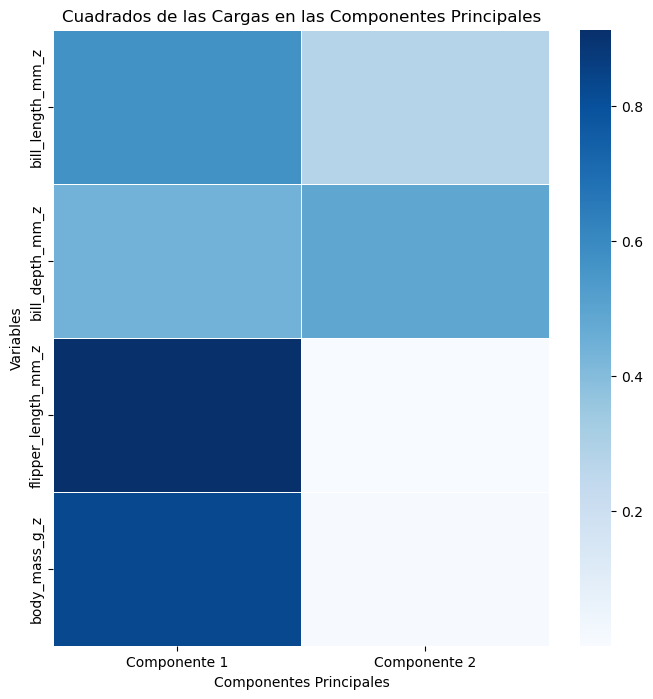

In [45]:
cos2 = correlaciones_notas_con_cp **2
fm2.plot_cos2_heatmap(cos2)

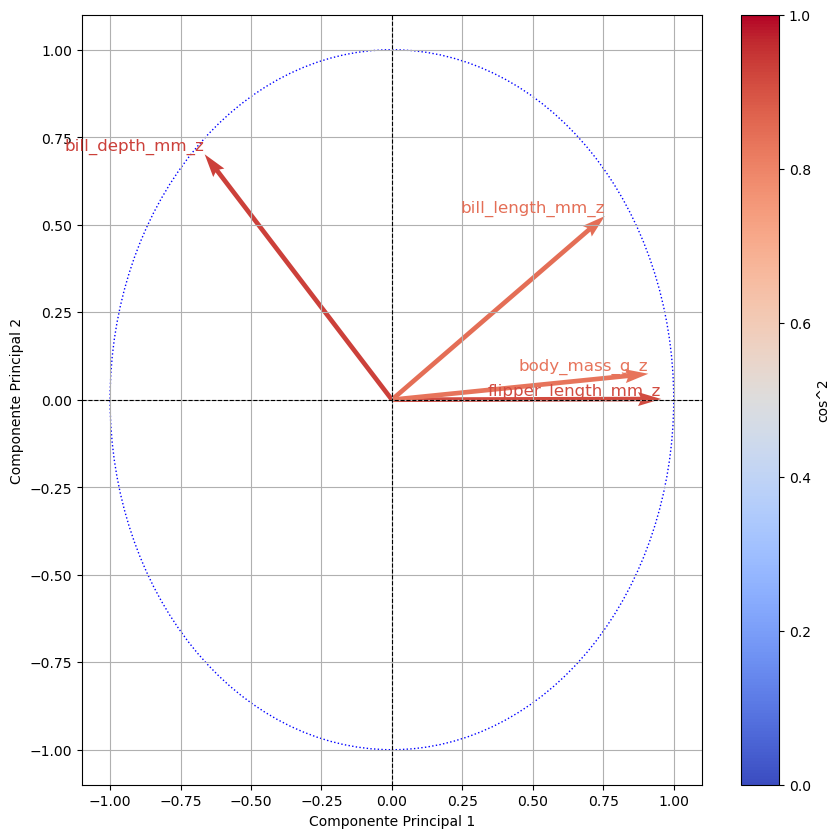

In [46]:
fm2.plot_corr_cos(fit.n_components, correlaciones_notas_con_cp)

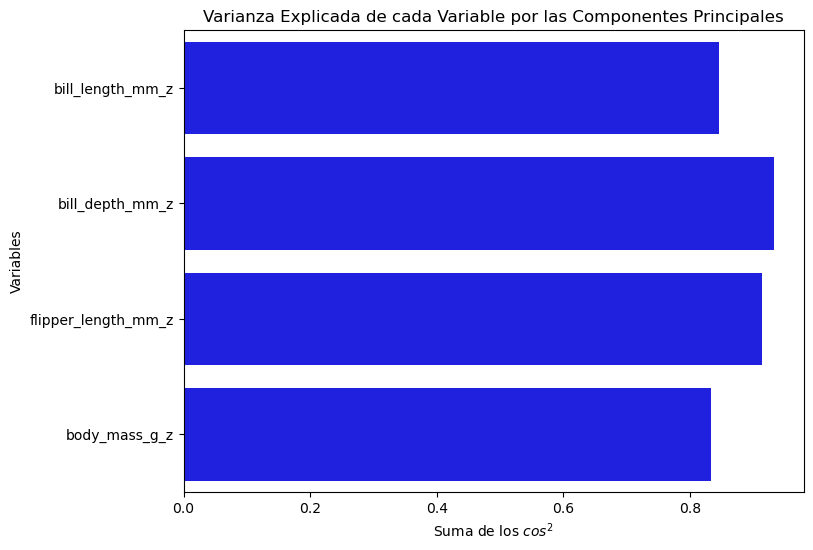

In [47]:
fm2.plot_cos2_bars(cos2)

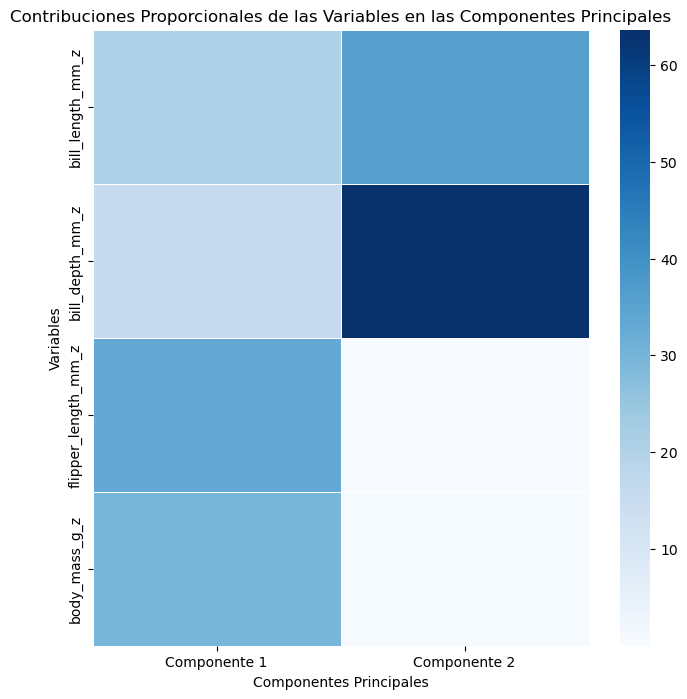

In [48]:
contribuciones_proporcionales = fm2.plot_contribuciones_proporcionales(cos2,autovalores,fit.n_components)

In [49]:
print(contribuciones_proporcionales)

                     Componente 1  Componente 2
bill_length_mm_z        20.725286     35.644619
bill_depth_mm_z         16.026786     63.643150
flipper_length_mm_z     33.179135      0.000521
body_mass_g_z           30.068793      0.711710


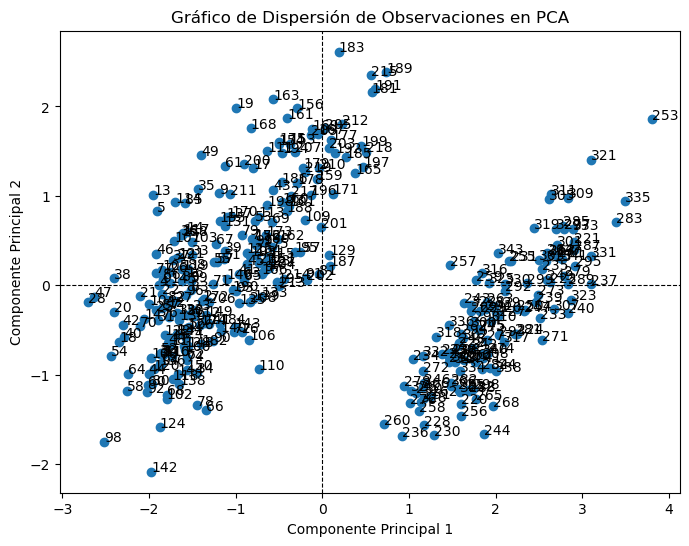

In [50]:
fm2.plot_pca_scatter(pca, datos_estandarizados, fit.n_components)

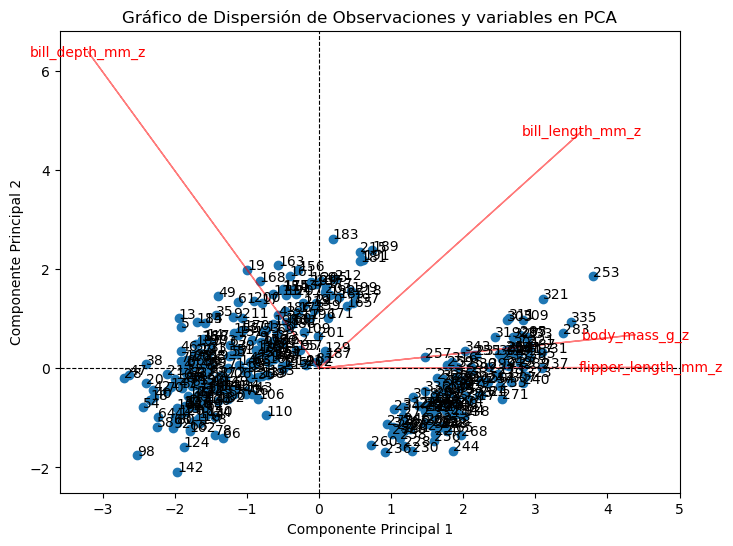

In [51]:
fm2.plot_pca_scatter_with_vectors(pca, datos_estandarizados, fit.n_components, fit.components_)

In [52]:
# DataFrame vacío para almacenar los resultados
resultados_maximos = pd.DataFrame()

# Ciclo for para obtener DataFrames en cada iteración
for i in numericas_estandarizados:
    # Obtenemos un DataFrame con el maximo valor para cada cariable
    df = datos_estandarizados[datos_estandarizados[i]==datos_estandarizados[i].max()]
    # Agregar el DataFrame actual a resultados_totales
    resultados_maximos = resultados_maximos.append(df)

# Imprimir el DataFrame resultante
print(resultados_maximos)

     bill_length_mm_z  bill_depth_mm_z  flipper_length_mm_z  body_mass_g_z
253          2.875868        -0.076662             2.071398       2.308053
19           0.381186         2.205397            -0.492496      -0.002191
283          1.903676        -0.735923             2.142618       1.808541
237          0.968170        -0.989485             1.430425       2.620248


In [53]:
# Calcular las componentes principales para el conjunto de datos combinado
componentes_principales = pca.transform(datos_estandarizados)
# componentes_principales_sup

In [54]:
# Calcular las componentes principales para el conjunto de datos combinado
# y renombra las componentes
resultados_pca = pd.DataFrame(fit.transform(datos_estandarizados),
    columns = ['Componente {}'. format(i) for i in range (1 , fit.n_components_+1)],
    index = datos_estandarizados.index )
# resultados_pca_sup

In [55]:
# Incorporamos la variable categ ´o rica " EXTRA_ESC " en los datos
datos_componentes = pd.concat([datos_estandarizados, resultados_pca, datos[categoricas]] , axis =1)


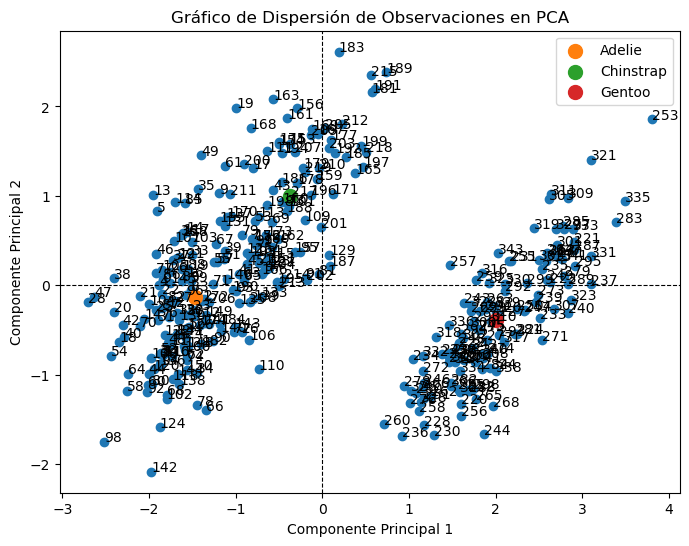

In [56]:
fm2.plot_pca_scatter_with_categories(datos_componentes, componentes_principales, fit.n_components, "species")

In [57]:
contribuciones_proporcionales_01 = contribuciones_proporcionales / 100

In [58]:
resultados = []

for index, row in datos_componentes[numericas_estandarizados].iterrows():
    resultado = 0
    for index2, row2 in contribuciones_proporcionales_01.iterrows():
        resultado += (row[index2]*row2[0] + row[index2]*row2[1])
    resultados.append(resultado)

datos_componentes['indice_ponderado'] = resultados

In [59]:
datos_componentes

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z,Componente 1,Componente 2,species,island,sex,prop_missings,indice_ponderado
0,-0.884499,0.785449,-1.418347,-0.564142,-1.843445,0.047702,Adelie,Torgersen,Male,0.0,-0.517073
1,-0.811126,0.126188,-1.062250,-0.501703,-1.306762,-0.428348,Adelie,Torgersen,Female,0.0,-0.863575
2,-0.664380,0.430462,-0.421277,-1.188532,-1.369181,-0.154476,Adelie,Torgersen,Female,0.0,-0.537176
4,-1.324737,1.089724,-0.563715,-0.938776,-1.878827,-0.002048,Adelie,Torgersen,Female,0.0,-0.354570
5,-0.847812,1.748985,-0.777373,-0.689020,-1.911748,0.829210,Adelie,Torgersen,Male,0.0,0.445491
...,...,...,...,...,...,...,...,...,...,...,...
338,0.601305,-1.750171,0.931890,0.903175,2.006436,-0.958909,Gentoo,Biscoe,Female,0.0,-0.468206
340,0.527932,-1.445897,1.003109,0.809516,1.840886,-0.767714,Gentoo,Biscoe,Female,0.0,-0.272349
341,1.188289,-0.735923,1.501644,1.933419,2.760742,0.288886,Gentoo,Biscoe,Male,0.0,1.176884
342,0.234440,-1.192335,0.789451,1.246590,1.722364,-0.704269,Gentoo,Biscoe,Female,0.0,-0.172135


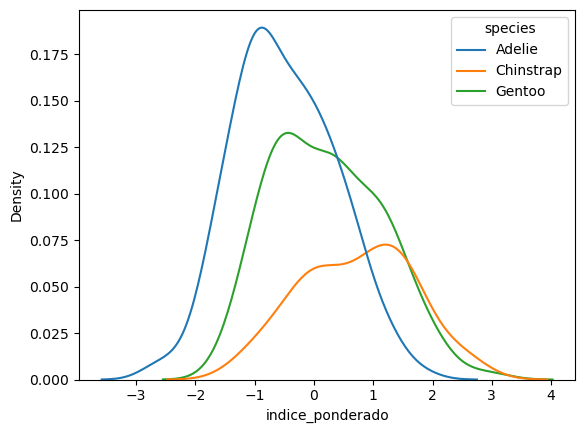

In [60]:
sns.kdeplot(data=datos_componentes, x=datos_componentes['indice_ponderado'], hue=datos_componentes['species'])
plt.show()

In [61]:
resultados2 = []

for index, row in datos_componentes[numericas_estandarizados].iterrows():
    resultado2 = 0
    for index2, row2 in cos2.iterrows():
        resultado2 += (row[index2]*row2[0] + row[index2]*row2[1])
    resultados2.append(resultado2)

datos_componentes['indice_ponderado2'] = resultados2

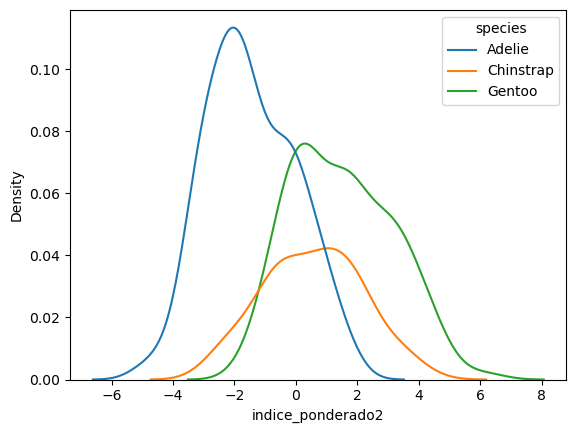

In [62]:
sns.kdeplot(data=datos_componentes, x=datos_componentes['indice_ponderado2'], hue=datos_componentes['species'])
plt.show()

In [63]:
resultados3 = []

for index, row in datos[numericas].iterrows():
    resultado3 = 0
    for index2, row2 in cos2.iterrows():
        index2 = index2.replace('_z','')
        resultado3 += (row[index2]*row2[0] + row[index2]*row2[1])
    resultados3.append(resultado3)

datos_componentes['indice_ponderado3'] = resultados3

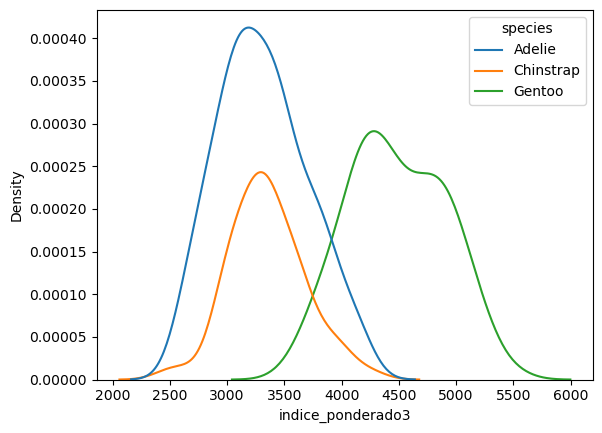

In [64]:
sns.kdeplot(data=datos_componentes, x=datos_componentes['indice_ponderado3'], hue=datos_componentes['species'])
plt.show()

In [65]:
dc1 = datos_componentes[datos_componentes['species'] == 'Adelie']['indice_ponderado3'].mean()

In [66]:
dc2 = datos_componentes[datos_componentes['species'] == 'Chinstrap']['indice_ponderado3'].mean()

In [67]:
dc3 = datos_componentes[datos_componentes['species'] == 'Gentoo']['indice_ponderado3'].mean()

In [68]:
print(f'Adelie:\t\t {dc1}\nChinstrap:\t {dc2}\nGentoo:\t\t {dc3}')


Adelie:		 3308.0662697576
Chinstrap:	 3349.0231206590242
Gentoo:		 4483.5659820690325


# Analisis Clustering

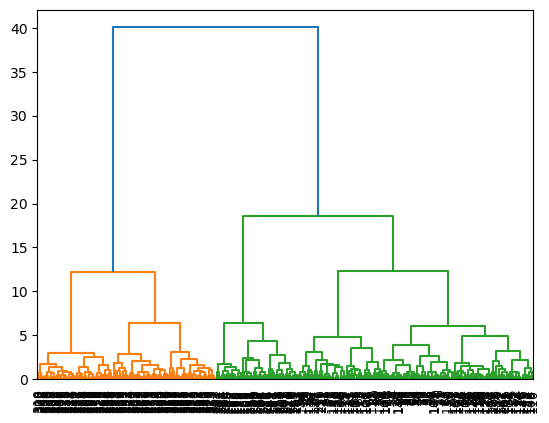

In [69]:
# Calculate the linkage matrix
linkage_matrix = sch.linkage(datos_estandarizados, method='ward')  # You can choose a different linkage method if needed

# Create the dendrogram
dendrogram = sch.dendrogram(linkage_matrix, labels=datos_estandarizados.index, leaf_font_size=9, leaf_rotation=90)

# Display the dendrogram
plt.show()

In [70]:
# Assign data points to 3 clusters
num_clusters = 3
cluster_assignments = sch.fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Display the cluster assignments
print("Cluster Assignments:", cluster_assignments)

Cluster Assignments: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 2 2 2 2 2 2 3 2 3 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 2 2 2 2 2 2 3 2 3 2
 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 2 3 2 2 2 2 3 2 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


In [71]:
# Create a new column 'Cluster' and assign the 'cluster_assignments' values to it
datos['Cluster'] = cluster_assignments

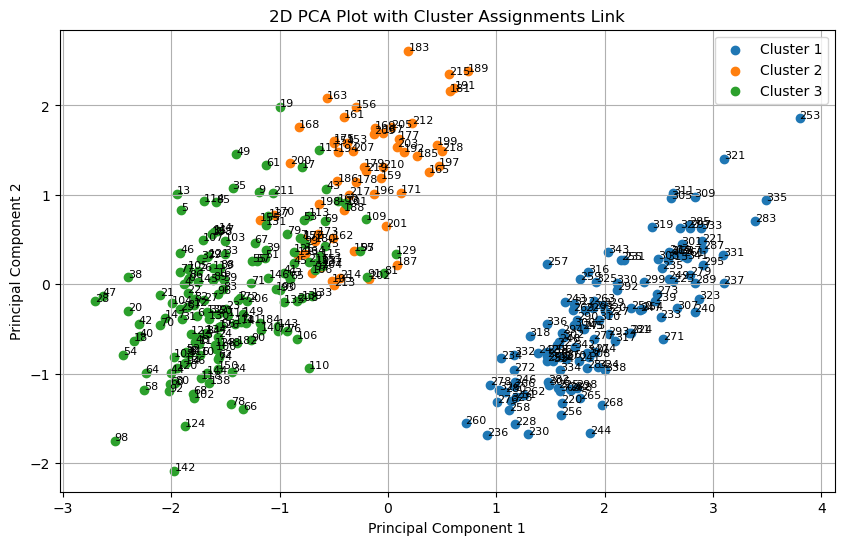

In [72]:
# Assuming 'df' is your original DataFrame with data
# 'cluster_assignments' contains cluster assignments

# Step 1: Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(datos_estandarizados)

# Create a new DataFrame for the 2D principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(cluster_assignments):
    plt.scatter(df_pca.loc[cluster_assignments == cluster, 'PC1'],
                df_pca.loc[cluster_assignments == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(datos_estandarizados.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments Link")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

In [73]:
# Assign data points to 4 clusters
num_clusters = 4
cluster_assignments = sch.fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Display the cluster assignments
print("Cluster Assignments:", cluster_assignments)

Cluster Assignments: [4 4 4 4 3 4 3 4 3 4 4 4 3 3 4 4 3 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4
 4 3 4 3 4 3 4 3 4 4 4 3 4 3 4 3 4 3 4 3 4 4 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4
 3 4 4 4 3 4 3 4 4 4 3 4 4 4 4 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 4 4 3 4 3 4 3
 4 3 3 3 4 3 4 4 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 4 4 3 4 3 4 4 4 4 4 4 3 4 4
 4 4 3 2 2 2 2 2 2 4 2 3 2 2 2 2 2 2 2 2 2 2 2 4 2 4 2 2 2 2 2 2 2 4 2 4 2
 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 4 2 2 3 2 2 2 2 3 2 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


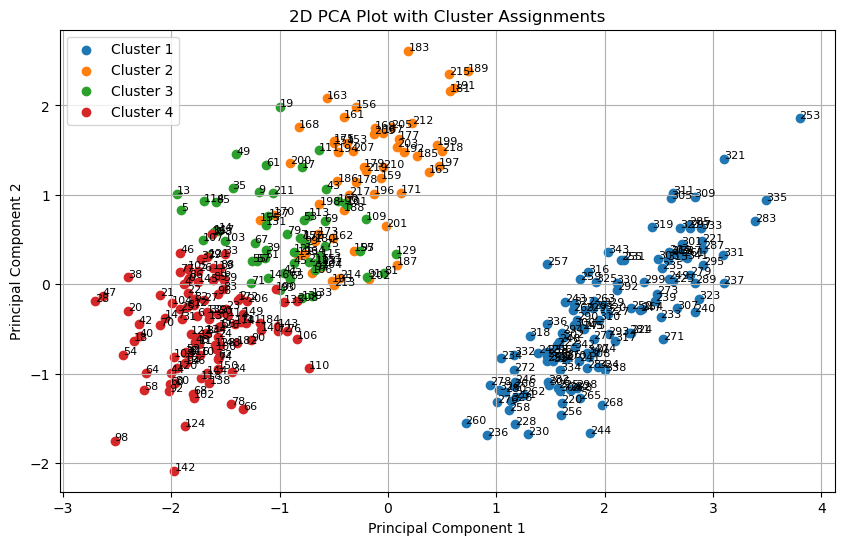

In [74]:
# Assuming 'df' is your original DataFrame with data
# 'cluster_assignments' contains cluster assignments

# Step 1: Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(datos_estandarizados)

# Create a new DataFrame for the 2D principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(cluster_assignments):
    plt.scatter(df_pca.loc[cluster_assignments == cluster, 'PC1'],
                df_pca.loc[cluster_assignments == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(datos_estandarizados.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

In [75]:
# Set the number of clusters (k=4)
k = 4

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, random_state=0)

# Fit the KMeans model to your standardized data
kmeans.fit(datos_estandarizados)

# Get the cluster labels for your data
kmeans_cluster_labels = kmeans.labels_

print(kmeans_cluster_labels)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 0 2 0 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 3 1 3
 1 1 3 3 1 3 3 3 1 3 1 3 1 3 1 3 1 1 3 3 3 3 3 3 1 3 1 1 3 3 1 1 1 3 1 3 1
 3 1 3 3 1 3 3 1 3 1 3 1 3 1 3 3 3 3 3 1 3 1 3 1 3 1 3 1 3 1 3 1 1 3 3 1 3
 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 1 3 3 1 3 1 3 1 3 1 3 1 3 1 1 1 3 1
 3 1 3 1 3 3 1 3 1]


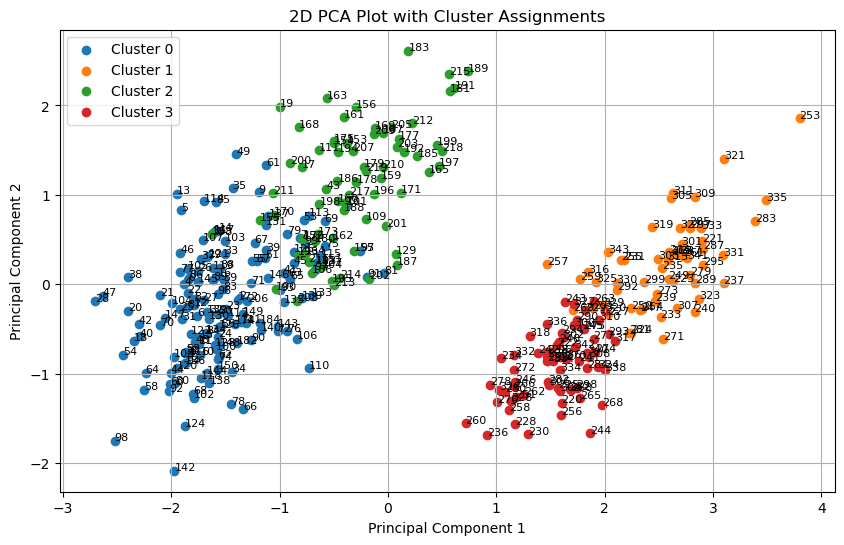

In [76]:
# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(kmeans_cluster_labels):
    plt.scatter(df_pca.loc[kmeans_cluster_labels == cluster, 'PC1'],
                df_pca.loc[kmeans_cluster_labels == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(datos_estandarizados.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

In [77]:
#Create an array to store the WCSS values for different values of K:
wcss = []

for k in range(1, 11):  # You can choose a different range of K values
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(datos_estandarizados)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS value

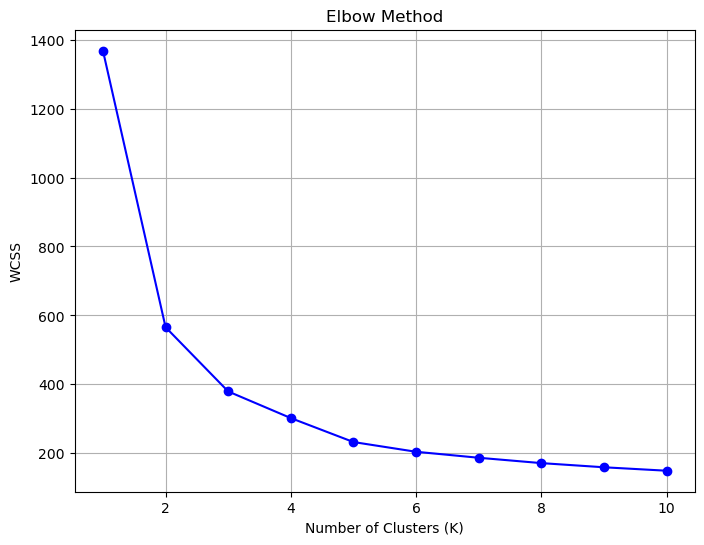

In [78]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [79]:
datos_estandarizados

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z
0,-0.884499,0.785449,-1.418347,-0.564142
1,-0.811126,0.126188,-1.062250,-0.501703
2,-0.664380,0.430462,-0.421277,-1.188532
4,-1.324737,1.089724,-0.563715,-0.938776
5,-0.847812,1.748985,-0.777373,-0.689020
...,...,...,...,...
338,0.601305,-1.750171,0.931890,0.903175
340,0.527932,-1.445897,1.003109,0.809516
341,1.188289,-0.735923,1.501644,1.933419
342,0.234440,-1.192335,0.789451,1.246590


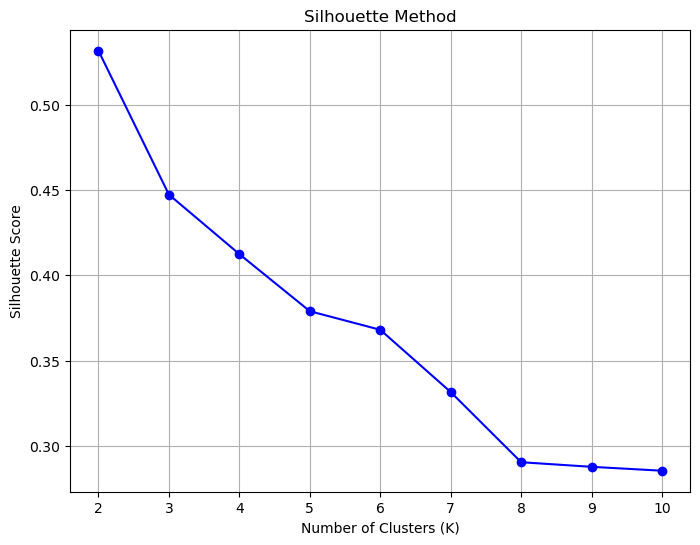

In [80]:
#Create an array to store silhouette scores for different values of K

silhouette_scores = []

#Run K-means clustering for a range of K values and calculate the silhouette score for each K:

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(datos_estandarizados)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(datos_estandarizados, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [81]:
# Assuming 'df_std_distance' is your standardized data and '4' is the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(datos_estandarizados)
labels = kmeans.labels_

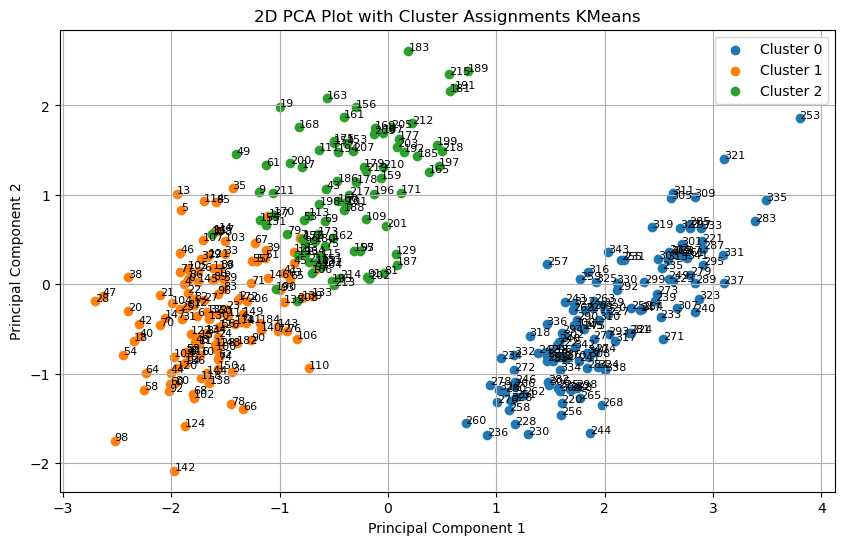

In [82]:
# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(labels):
    plt.scatter(df_pca.loc[labels == cluster, 'PC1'],
                df_pca.loc[labels == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(datos_estandarizados.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments KMeans")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

In [83]:
silhouette_values = silhouette_samples(datos_estandarizados, labels)
silhouette_values

array([ 0.48598349,  0.48990169,  0.38278372,  0.49223797,  0.27553305,
        0.53181818,  0.12385805,  0.55257088, -0.01785647,  0.56485269,
        0.53508006,  0.42058957,  0.22588427,  0.23036376,  0.58824905,
        0.43106836,  0.14247689,  0.57001619,  0.27693188,  0.48819934,
        0.53266932,  0.51942683,  0.51801534,  0.49216233,  0.54442792,
        0.43631301,  0.45547354,  0.44566182,  0.3622944 ,  0.45563392,
        0.50864829,  0.52114137,  0.34568109,  0.5181753 ,  0.11401915,
        0.33360086,  0.31057527,  0.49416932,  0.21464358,  0.56619842,
        0.25604292,  0.5571118 ,  0.2537484 ,  0.53256702,  0.21275294,
        0.37371701,  0.47883   ,  0.59474082,  0.04336108,  0.52679891,
        0.27992995,  0.58742763,  0.07287038,  0.53186049,  0.29292724,
        0.54825854,  0.31116807,  0.4901811 ,  0.46308418,  0.55843131,
        0.03679082,  0.55850247,  0.25141367,  0.51860437,  0.22965161,
        0.4756188 ,  0.23682571,  0.5202627 ,  0.07510213,  0.52

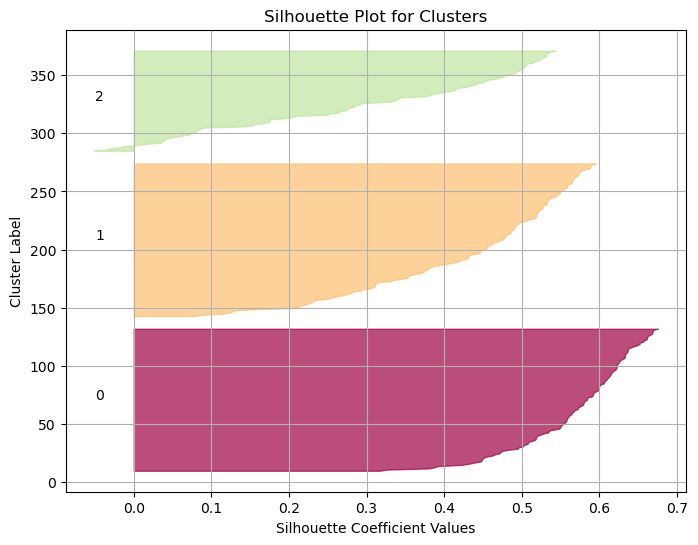

In [84]:
plt.figure(figsize=(8, 6))

y_lower = 10
for i in range(3):
    ith_cluster_silhouette_values = silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.get_cmap("Spectral")(float(i) / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.title("Silhouette Plot for Clusters")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.grid(True)
plt.show()

In [85]:
# Add the labels as a new column to the DataFrame
datos_estandarizados['label'] = labels

numericas_estandarizados = numericas_estandarizados.__add__(['label'])

In [86]:
# Sort the DataFrame by the "label" column
datos_estandarizados_sort = datos_estandarizados[numericas_estandarizados].sort_values(by="label")
# Set the 'A' column as the index
datos_estandarizados_sort['label']

343    0
250    0
251    0
252    0
253    0
      ..
205    2
123    2
207    2
200    2
171    2
Name: label, Length: 342, dtype: int32

In [87]:
arrLabel = np.array(datos_estandarizados_sort['label'])

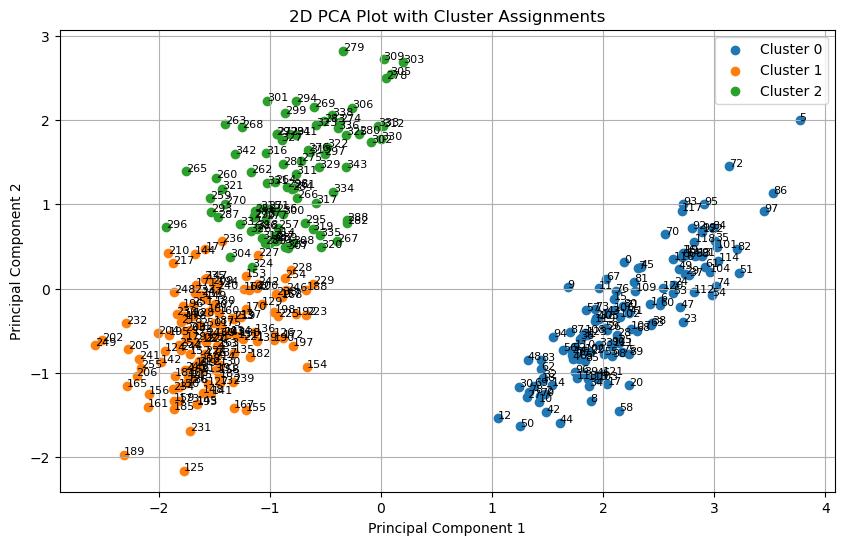

In [88]:
# Assuming 'df' is your original DataFrame with data
# 'cluster_assignments' contains cluster assignments

# Step 1: Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(datos_estandarizados_sort)

# Create a new DataFrame for the 2D principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))

# Loop through unique cluster assignments and plot data points with the same color
for cluster in np.unique(arrLabel):
    plt.scatter(df_pca.loc[arrLabel == cluster, 'PC1'],
                df_pca.loc[arrLabel == cluster, 'PC2'],
                label=f'Cluster {cluster}')
# Add labels to data points
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(datos_estandarizados.index[i]), fontsize=8)

plt.title("2D PCA Plot with Cluster Assignments")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

In [89]:
# Group the data by the 'label' column and calculate the mean of each group
cluster_centroids = datos_estandarizados_sort.groupby('label').mean()
cluster_centroids.round(2)
# 'cluster_centroids' now contains the centroids of each cluster

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z
label,,,,
0,0.66,-1.10,1.16,1.09
1,-1.05,0.49,-0.89,-0.77
2,0.66,0.82,-0.29,-0.37


In [91]:
# Add the labels as a new column to the DataFrame
datos['label'] = labels
# Sort the DataFrame by the "label" column
df_sort = datos.sort_values(by="label")

numericas.append('label')

# Group the data by the 'label' column and calculate the mean of each group
cluster_centroids_orig = df_sort[numericas].groupby('label').mean()
cluster_centroids_orig.round(2)
# 'cluster_centroids' now contains the centroids of each cluster

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
label,,,,
0,47.50,14.98,217.19,5076.02
1,38.21,18.11,188.40,3584.66
2,47.53,18.76,196.90,3902.01
